In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import pickle



In [2]:
from ucimlrepo import fetch_ucirepo
parkinsons_telemonitoring = fetch_ucirepo(id=189)
df = parkinsons_telemonitoring.data.features
y = parkinsons_telemonitoring.data.targets
df["Target"] = y["total_UPDRS"]
df.isnull().sum()
corr = df.corr()
corr["Target"].sort_values()

X = df.drop(columns=["Target", "sex", "NHR"])
y = df["Target"]

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_24656\1783103930.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Target"] = y["total_UPDRS"]


In [3]:
# Definir el modelo RandomForest
random_forest = RandomForestRegressor()

# Definir los hiperparámetros para GridSearchCV
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}


In [4]:
# Búsqueda de hiperparámetros y ajuste del modelo RandomForest
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_random_forest = grid_search.best_estimator_
print(f"Best parameters for RandomForest: {grid_search.best_params_}")


Best parameters for RandomForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [5]:
# Evaluar el desempeño del modelo RandomForest en el conjunto de prueba y guardar resultados
y_pred_rf = best_random_forest.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rf_results = {
    "model": best_random_forest,
    "predictions": y_pred_rf,
    "mse": mse_rf,
    "r2": r2_rf,
    "mae": mae_rf
}
print(f"RandomForest - MSE: {mse_rf}, R2: {r2_rf}, MAE: {mae_rf}")


RandomForest - MSE: 5.197062503910637, R2: 0.953100624726464, MAE: 1.0611164042553207


In [6]:
# Guardar el modelo 
with open('RandomForest_model.pkl', 'wb') as file:
    pickle.dump(best_random_forest, file)
with open('RandomForest_results.pkl', 'wb') as file:
    pickle.dump(rf_results, file)


In [7]:
# Función para graficar curvas de aprendizaje
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


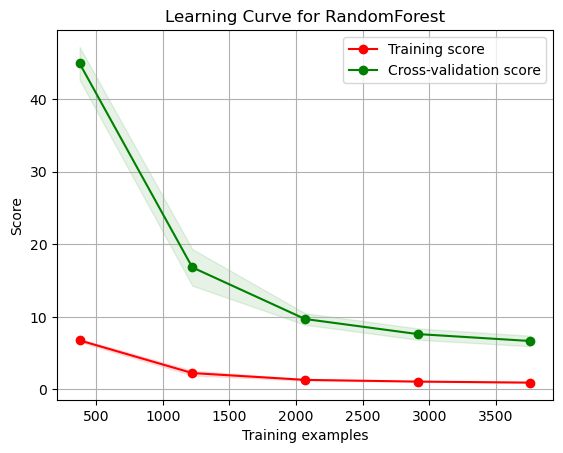

In [8]:
# Graficar curva de aprendizaje para el modelo RandomForest
plot_learning_curve(best_random_forest, "Learning Curve for RandomForest", X_train, y_train, cv=5)
plt.show()


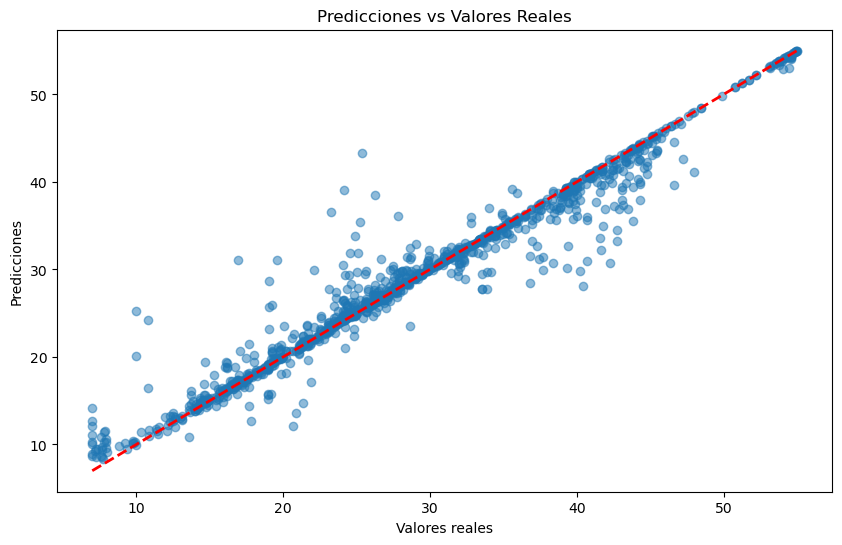

In [11]:
# Graficar predicciones versus valores reales para el modelo RandomForest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()